In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
import os
import wordcloud

# 대회의 목적
In this competition, you’ll identify elements in student writing. More specifically, you will automatically segment texts and classify argumentative and rhetorical elements in essays written by 6th-12th grade students. 
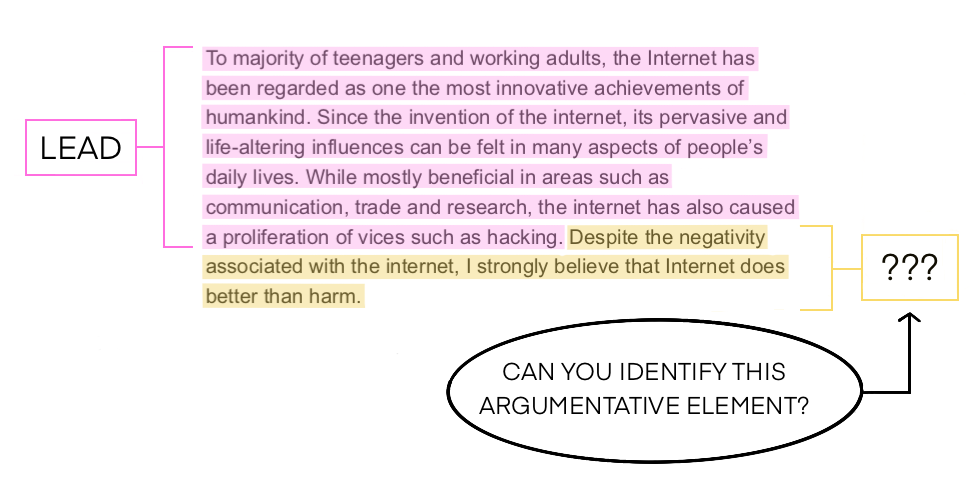


### 참고 notebook
- https://www.kaggle.com/erikbruin/nlp-on-student-writing-eda
- https://www.kaggle.com/minyeongkang/eda-feedback-prize/edit

 **Discourse란?** <br>
담화, 담론, 논설을 의미

### Checkpoint

-  **Discussion** - [issue 확인(PredictionString and DiscourseText차이)](https://www.kaggle.com/c/feedback-prize-2021/discussion/297591)
    - 캐글 데이터를 100프로 신뢰하진 말자!
-  **Discussion** -  [additional information 확인](https://www.kaggle.com/c/feedback-prize-2021/discussion/297688)
    - Discussion에서 주최자 측에서 올리는 additional information을 꼭 확인하자!

we have a bunch of essays written by kids in the age range of about 12-18 years old in which we have to find word sequences that can be classified as one of 7 **"discourse types"**.  <br>
These are:
- Lead : 인용구, 요약, 주의를 이끌 수 있는 문장으로 시작하면 labeling
- Position : 의견, 결론 (main question에 대한)
- Claim : position을 support하는 주장
- counterclaim : 반대 주장
- rebuttal : counterclaim을 뒷받침해주는 주장
- evidence : claim, conuterclaim, rebuttal을 뒷받침해주는 생각, 예시
- concluding summary : 주장에 대한 결론

#### +additional info : Rubric

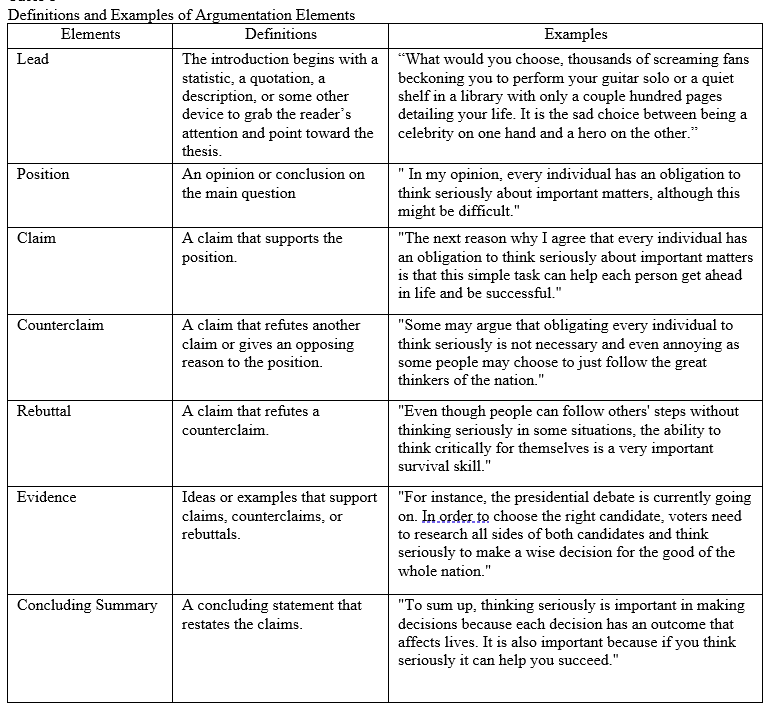




### Column Description
- id - ID code for essay response
- discourse_id - ID code for discourse element
- discourse_start - character position where discourse element begins in the essay response
- discourse_end - character position where discourse element ends in the essay response
- discourse_text - text of discourse element
- discourse_type - classification of discourse element
- discourse_type_num - enumerated class label of discourse element
- predictionstring - the word indices of the training sample, as required for predictions (discourse_text의  단어 인덱스)

#### +additional info : predicitonstring<br>
The **predictionstring** column takes the full text and the discourse_start and discourse_end character indices to create the list of word indices. The code used to generate predictionstring is below:

```def calc_word_indices(full_text, discourse_start, discourse_end):
start_index = len(full_text[:discourse_start].split())
token_len = len(full_text[discourse_start:discourse_end].split())
output = list(range(start_index, start_index + token_len))
if output[-1] >= len(full_text.split()):
output = list(range(start_index, start_index + token_len-1))
return output```



In [ ]:
train = pd.read_csv('../input/corrected-dataset/corrected_train.csv')
train.head(10)

In [ ]:
train.info()

In [ ]:
# float type -> int type 으로 변환
train[['discourse_id','discourse_start','discourse_end']]=train[['discourse_id','discourse_start','discourse_end']].astype(int)
train.info()

In [ ]:
sample_submission = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')

# 전체 문단 text 파일 
train_txt = glob('../input/feedback-prize-2021/train/*.txt') 
test_txt = glob('../input/feedback-prize-2021/test/*.txt')

In [ ]:
!cat ../input/feedback-prize-2021/train/423A1CA112E2.txt

In [ ]:
train.loc[(train['id'] == "423A1CA112E2")]

## discourse_text 와 predictionstring 길이 확인

In [ ]:
train.columns

In [ ]:
train["discourse_len"]=train["discourse_text"].apply(lambda x : len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x : len(x.split()))
display_train = ['discourse_id','discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[display_train].head()

In [ ]:
train[display_train].head(10)

In [ ]:
# 뒷쪽에 혹시라도 discourse_text 길이와 predictionstring 길이 다른 컬럼 있는 지 확인
dif = train[train['discourse_len'] != train["pred_len"]]
dif.head(30)

#### 468행의 discourse_text 길이와 predictionstring 길이가 다르다

In [ ]:
# dif의 첫행의 문장 확인 ['discourse_text']
print(dif['discourse_text'].values[0])
# dif의 첫행의 문장 단어로 쪼개서 확인
print(dif['discourse_text'].values[0].split())
# 길이 확인
print(len(dif['discourse_text'].values[0].split()))

In [ ]:
# dif의 첫행의 문장 확인 ['predictionstring']
print(dif['predictionstring'].values[0])
# dif의 첫행의 문장 단어로 쪼개서 확인
print(dif['predictionstring'].values[0].split())
# 길이 확인
print(len(dif['predictionstring'].values[0].split()))

In [ ]:
# dif의 첫행의 문장 확인 ['discourse_text']
print(dif['discourse_text'].values[100])
# dif의 첫행의 문장 단어로 쪼개서 확인
print(dif['discourse_text'].values[100].split())
# 길이 확인
print(len(dif['discourse_text'].values[100].split()))

In [ ]:
# dif의 첫행의 문장 확인 ['predictionstring']
print(dif['predictionstring'].values[100])
# dif의 첫행의 문장 단어로 쪼개서 확인
print(dif['predictionstring'].values[100].split())
# 길이 확인
print(len(dif['predictionstring'].values[100].split()))

> 기존 데이터 컬럼으로 비교하면 discourse_text 와 predictionstring 길이 차이 있지만 <br>
> **But, corrected_train 파일의 text_by_new_index와 new_predictionstring 컬럼 사용하면 길이 차이 없음!**

In [ ]:
train["text_index_len"]=train["text_by_new_index"].apply(lambda x : len(x.split()))
train["pred_len"] = train["new_predictionstring"].apply(lambda x : len(x.split()))
new_train = ['discourse_id','discourse_text', 'discourse_type','text_by_new_index','new_predictionstring', 'text_index_len', 'pred_len']
train[new_train].head()

In [ ]:
# 뒷쪽에 혹시라도 discourse_text 길이와 predictionstring 길이 다른 컬럼 있는 지 확인
dif = train[train['text_index_len'] != train["pred_len"]]
dif.head(30)

### discourse_type별  행의 개수의 분포

In [ ]:
fig = px.bar(x = np.unique(train["discourse_type"]),
y = [list(train["discourse_type"]).count(i) for i in np.unique(train["discourse_type"])] , 
            color = np.unique(train["discourse_type"]),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Discourse Type Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        template="plotly_white")
fig.show()

### Enumerated class label of Discourse Element Distribution

In [ ]:
fig = px.bar(x = np.unique(train["discourse_type_num"]),
y = [list(train["discourse_type_num"]).count(i) for i in np.unique(train["discourse_type_num"])] , 
            color = np.unique(train["discourse_type_num"]),
             color_continuous_scale="blues") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Enumerated class label of Discourse Element Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        template="plotly_white")
fig.show()

## discourse_type_num 별 essay안에 존재하는 비율

In [ ]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()

> 한 에세이에 예시가 5개 이상은 많이 없을 거라고 생각되기에 Evidence 5가 %가 작다고는 이해가 되지만 <br>
> Rebuttal2 Counterclaim2 왜이렇게 낮은건가? - 한 에세이의 반박은 거의 1번 정도 일어난다고 생각하자 일단

In [ ]:
data = train.groupby("discourse_type")[['new_end', 'new_start']].mean().reset_index().sort_values(by = 'new_start', ascending = False)
data.plot(x='discourse_type',
        kind='barh',
        stacked=False,
        title='Average start and end position absolute',
        figsize=(12,4))
plt.show()

In [ ]:
# Lead의 총 갯수 
len(train[train["discourse_type"]=='Lead'])

In [ ]:
# Lead new_start가 왜 없나?
check = train[(train["discourse_type"]=='Lead') & (train['new_start'] < 10)]
check

> Lead 총 9305개 중 7640개의 discourse_start가 10보다 더 전의 인덱스에서 시작한다는 것! (80%는 다 앞에 있다)

## discourse_type 에 따른 에세이 안에서의 위치는?

In [ ]:
train_first = train.drop_duplicates(subset = "id", keep = "first").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_first')
train_first['percent_first'] = round((train_first['counts_first']/train.id.nunique()),2)
train_last = train.drop_duplicates(subset = "id", keep = "last").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_last')
train_last['percent_last'] = round((train_last['counts_last']/train.id.nunique()),2)
train_first_last = train_first.merge(train_last, on = "discourse_type", how = "left")
train_first_last

> 분포 확인했을 때는 Lead가 40프로 정도는 앞에 없다는 것을 확인.

In [ ]:
train.head()

## discourse_type별 빈도수 높은 단어 뽑아보기

In [ ]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put dataframe of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

> discoure_type별 단어 빈도수 시각단어 다 비슷해서 유의미한 결과 X 

## 워드 클라우드

In [ ]:
wordcloud = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=5000,
                      width = 600, height = 400,
                      background_color='black').generate(' '.join(txt for txt in train["discourse_text"]))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [ ]:
train.describe()

## discourse_text 길이 분포 시각화

In [ ]:
train["discourse_len"] = train["discourse_end"] - train["discourse_start"]
fig = px.histogram(data_frame= train,x = "discourse_len",  marginal="violin",nbins = 400 )
fig.update_layout(template="plotly_white")
fig.show()

-> 한 discourse 길이가 2000자, 3000자 이상? discourse type이 제대로 안나눠진건가? <br>
너무 길면 이상치로 생각하고 제거하자

## discourse_start 수치 분포 시각화

In [ ]:
fig = px.histogram(data_frame= train,x = "discourse_start",  marginal="violin" ,nbins = 400)
fig.update_layout(template="plotly_white")
fig.show()

## discourse_end 수치 분포 시각화

In [ ]:
fig = px.histogram(data_frame= train,x = "discourse_end",  marginal="violin" ,nbins = 400)
fig.update_layout(template="plotly_white")
fig.show()

## 텍스트 시각화

In [ ]:
train_dir = "../input/feedback-prize-2021/train"
test_dir = "../input/feedback-prize-2021/test"
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

for file in range(len(train_files)):
    train_files[file] = str(train_dir) + "/" +  str(train_files[file])
for file in range(len(test_files)):
    test_files[file] = str(test_dir) + "/" +  str(test_files[file])
                                                  
r = 20
ents = []
for i, row in train[train['id'] == train_files[r][35:-4]].iterrows():
    ents.append({
                    'start': int(row['discourse_start']), 
                     'end': int(row['discourse_end']), 
                     'label': row['discourse_type']
                })

with open(train_files[r], 'r') as file: data = file.read()

doc2 = {
    "text": data,
    "ents": ents,
}

colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
options = {"ents": train.discourse_type.unique().tolist(), "colors": colors}
spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

## 이제 Essay로 묶어서 한번 살펴보자

In [ ]:
train['full_text'] = train['discourse_text'].groupby(train['id']).transform(lambda x: ' '.join(x))

In [ ]:
train.full_text.iloc[0]

### Essay 길이 확인

In [ ]:
text_length = train['full_text'].drop_duplicates().apply(len)

fig = plt.figure(figsize=(10,8))

ax1 = text_length.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Essay Length Distribution')
ax1.set_xlabel("Essay Length")
ax1.set_ylabel("Frequency")

plt.show()

# 왜 Longformer가 성능이 좋을까?
Longformer : The Long-Document transformer

출처 - https://www.kaggle.com/c/feedback-prize-2021/discussion/296551
Time and Space complexity for training and inference with transformer models like BERT is O(N^2) where N is the maximum sequence length.
It means that a max sequence length of 1024 will take 4x the computation and 4x the memory as compared to a model with a max sequence length of 512.
This makes the model unable to process long sequences as its self-attention mechanism scales quadratically with the sequence length as each token in the input attends to every other token.
This is where transformer architectures like Longformer and BigBird come in. Longformer has an attention mechanism that scales linearly with the sequence length, which makes it easier to process documents with thousands of tokens.
As a lot of the student essays in the competition data go beyond 512 tokens, so we would need an architecture like Longformer or BigBird to fit the full essay without truncation. 

---
[번역]
> BERT와 같은 트랜스포머 모델을 사용한 ``훈련과 추론의 시간과 공간의 복잡성은 O(N^2)``입니다. 여기서 N은 최대 시퀀스 길이입니다.
> 이는 최대 시퀀스 길이가 512인 모델에 비해 최대 시퀀스 길이가 1024인 경우 계산이 4배이고 메모리가 4배가 됨을 의미합니다. 
> 이렇게 하면 입력의 각 토큰이 다른 모든 토큰에 해당하므로 셀프 어텐션 메커니즘이 시퀀스의 길이에 비례하여 확장되므로 모델이 긴 시퀀스를 처리할 수 없게 됩니다.

> 여기서 Longformer와 BigBird와 같은 트랜스포머 아키텍처가 등장합니다. ``Longformer``는 시퀀스의 길이에 비례하여 스케일링하는 어텐션 메커니즘을 가지고 있어 수천 개의 토큰을 포함하는 문서를 쉽게 처리할 수 있습니다.
> 콘테스트 데이터의 학생 에세이의 대부분은 512 토큰을 초과하기 때문에 잘라내지 않고 전체 에세이를 얻으려면 Longformer 및 BigBird와 같은 아키텍처가 필요합니다.

#### Longformer : The Long-Document transformer
논문 - https://arxiv.org/pdf/2004.05150.pdf
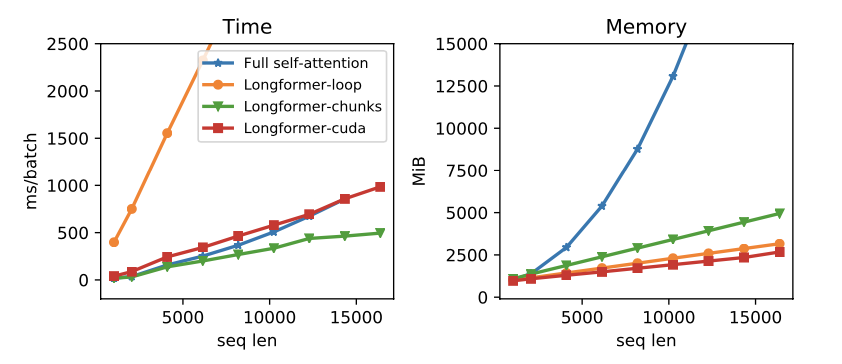
- 프레임워크를 파이토치 이용
- Longformer-loop, chunks, cuda는 셋업들
- cuda : 쿠다 커널
- chunks : Dilated 케이스냐 아니냐를 fine tuning에서 썻을 때 셋업
- loop : 파이토치에 메모리를 최적화하는 셋업 중 하나
- Time은 training time을 의미

> 파란색 그래프인 Full self-attention의 경우 입력 텍스트 전체를 다 보기 때문에 O(N^2)의 복잡도를 보인다.그래서 굉장히 많은 계산량을 필요로 하고, 시간과 메모리가 많이 소요된다고 한다.
> 이러한 기존의 Full self-attention이 가지는 n 제곱의 복잡도를 개선하기 위해서 Longformer가 탄생했다.

>+BERT 같은 경우 긴 문장이 주어졌을때, 긴 문장을 커버하기 이해 잘린(truncated) 시퀀스를 사용하게 된다. 일반적으로 512개의 token을 limit으로 가지고 있어, 길이가 512개로 쪼개져야해서 전체적인 문맥파악은 어렵다고 한다.

> Longformer는 문장이 길더라도 전체 텍스트를 고려하는 whole contextual representation을 학습하면서 모델 아키텍처에 의존하지 않고 성능을 높일 수 있다고 한다. 그래서 제안된 에텐션 패턴 방식은 아래와 같이 **(b) Sliding window attention (c) Dilated sliding window (d) Global+sliding window** 3가지 방식이 있다.

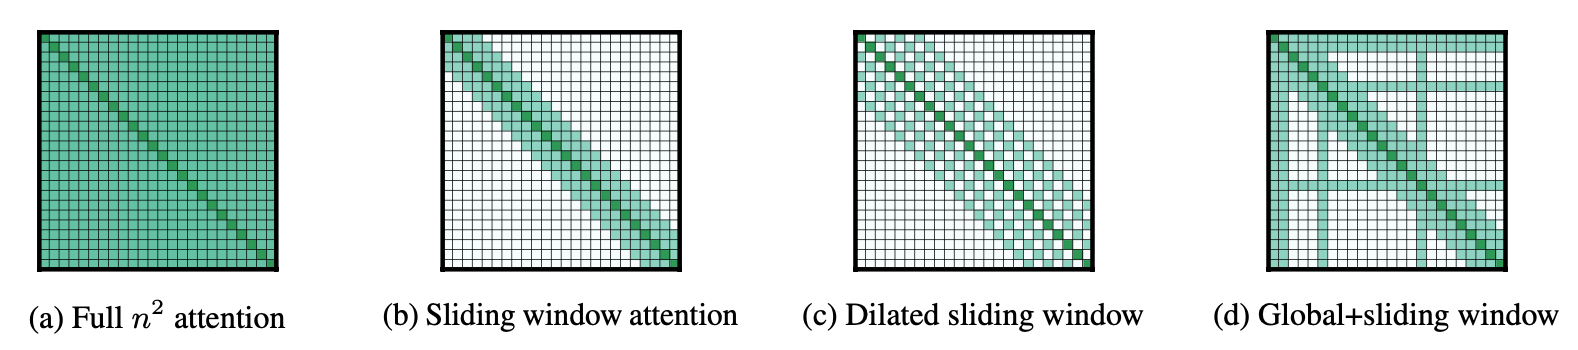

- 자세한 내용은 [논문 리뷰 영상](https://www.youtube.com/watch?v=i7aiBMDExmA) 참고!

## 참고 : 왜 Pytorch Longformer가  Tensorflow longformer 보다 성능이 좋은건가?
출처 - https://www.kaggle.com/c/feedback-prize-2021/discussion/300761

> [번역] <br>
PyTorch에서 작동하는 최적화가 Tensorflow로 변환되지 않거나 Tensorflow에서 주의 메커니즘이 작성된 방식에 실수가 있을 수 있습니다. Allen AI의 Longformer repo를 보면 순전히 PyTorch에 초점이 맞춰져 있고 특정 구현이 상당히 느렸다는 이전 기록이 있었습니다. :https://github.com/allenai/longformer

## two longformers are better than 1 
- https://www.kaggle.com/abhishek/two-longformers-are-better-than-1/notebook
- 코드 리뷰하고 싶었지만 파이토치로 짜져있어서 해석 불가,,
- 확실히 파이토치 코드가 쉽고 간결하게 짤 수 있다는 걸 볼 수 있었다.
- 이분이 two longformer을 왜 사용하진 노트북과 코멘트에도 설명하지 않을걸 봐선 그냥 어쩌다보니 두개를 붙여서 성능이 높인건가 짐작해본다